# Variances

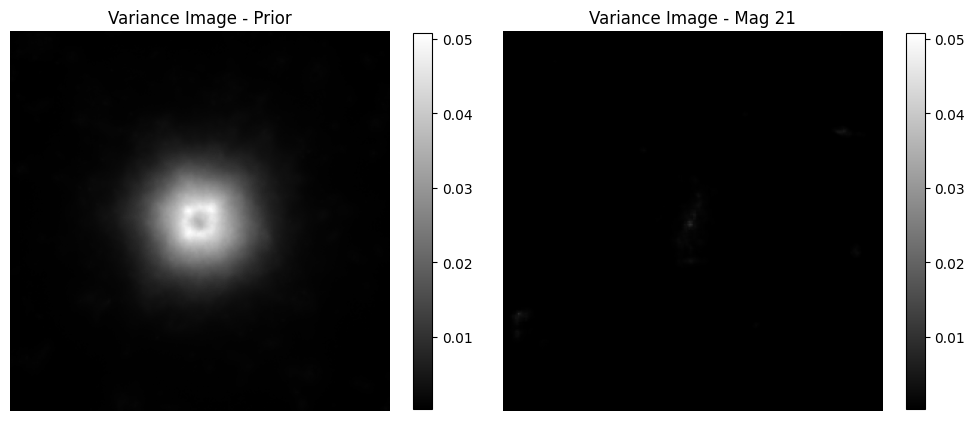

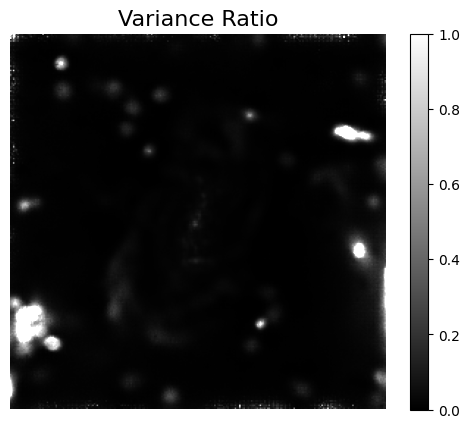

Average posterior variance in central circular region:  0.0006688136
Average posterior variance/prior variance ratio in central circular region:  0.019448187


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

def load_images_from_npz(file_path):
    data = np.load(file_path)
    images = data['arr_0']  # Assuming the default key in the .npz file is 'arr_0'
    return images

def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            try:
                img = Image.open(img_path)
                img_array = np.array(img).astype(np.float32) / 255.0
                images.append(img_array)
            except Exception as e:
                print(f"Could not load image {filename}: {e}")
    return np.array(images)

def compute_variance(images):
    # Compute pixel-wise variance across images
    variance = np.var(images, axis=0)
    # Take the mean across the three channels (axis=-1 represents the color channels)
    variance_mean = np.mean(variance, axis=-1)
    return variance_mean

def compute_mean(images):
    # Compute pixel-wise and channel-wise mean
    mean = np.mean(images, axis=0)
    return mean

def plot_variance(variance1, variance2, title1, title2):
    # Plot the average variance image across channels
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    vmin = variance1.min()
    vmax = variance1.max()

    im1 = axes[0].imshow(variance1, cmap='gray', vmin=vmin, vmax=vmax)
    axes[0].set_title(title1)
    axes[0].axis('off')
    fig.colorbar(im1, ax=axes[0], shrink=0.8)

    im2 = axes[1].imshow(variance2, cmap='gray', vmin=vmin, vmax=vmax)
    axes[1].set_title(title2)
    axes[1].axis('off')
    fig.colorbar(im2, ax=axes[1], shrink=0.8)
    
    plt.tight_layout()
    plt.show()

def plot_variance_ratio(variance1, variance2):
    # Calculate and plot the variance ratio
    ratio = variance1 / (variance2 + 1e-10)  # Add a small value to prevent division by zero

    plt.figure(figsize=(5, 5))  # Adjust figure size if needed
    plt.imshow(ratio, cmap='gray', vmin=0, vmax=1)
    plt.title('Variance Ratio', fontsize=16)
    plt.axis('off')
    cbar = plt.colorbar(shrink=0.8)  # Adjust color bar size
    plt.tight_layout()
    plt.show()

def create_circular_mask(h, w, center=None, radius=None):
    if center is None:  # use the middle of the image
        center = (int(w / 2), int(h / 2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w - center[0], h - center[1])
    
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)

    mask = dist_from_center <= radius
    return mask

def compute_mean_in_circular_region(image):
    # Assume all images have the same dimensions
    h, w = image.shape
    mask = create_circular_mask(h, w, radius=30)

    masked_means = []
    masked_img = image[mask]  # Apply the mask

    return np.mean(masked_img)  # Return the average

# Load images from the .npz files
file_path1 = '/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/samples/samples_1024x256x256x3_525k.npz'  # Update this with the actual file path
file_path2 = '/lustre/fswork/projects/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/samples/samples_256x256x256x3_inv_mag_real_HSC_test1.npz'  # Update this with the actual file path

train_imgs_path = '/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/Inception/Ideal_train/TNG_train_idealized'

#images_train = load_images_from_folder(train_imgs_path)#[:, 123:133, 123:133, :]

images1 = load_images_from_npz(file_path1)
images2 = load_images_from_npz(file_path2)

# Compute variance images
variance1 = compute_variance(images1)
variance2 = compute_variance(images2)

# Plot the variance images
plot_variance(variance1, variance2, 'Variance Image - Prior', 'Variance Image - Mag 21')

# Plot the variance ratio images
plot_variance_ratio(variance2, variance1)

# Compute the mean in the central circular region
mean_in_circular_region1 = compute_mean_in_circular_region(variance1)
mean_in_circular_region2 = compute_mean_in_circular_region(variance2)

mean_ratio_in_circular_region = compute_mean_in_circular_region(variance2 / (variance1 + 1e-10))


print("Average posterior variance in central circular region: ", mean_in_circular_region2)

print("Average posterior variance/prior variance ratio in central circular region: ", mean_ratio_in_circular_region)

# Averaged samples

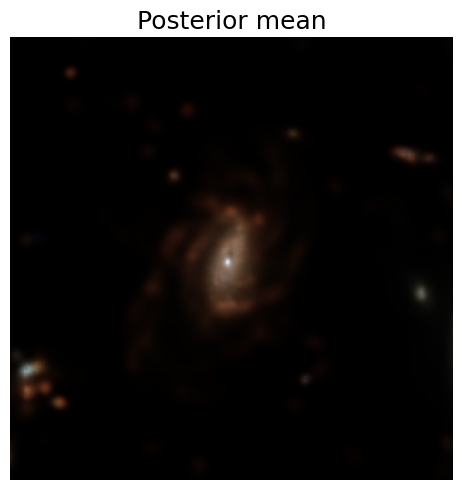

In [5]:
avg = compute_mean(images2)
plt.figure(figsize=(5, 5))  # Adjust figure size if needed
plt.imshow(avg.clip(0,1))
plt.title('Posterior mean', fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.show()

# Histograms

In [3]:
import os
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import os
#plt.style.use(astropy_mpl_style)
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torchvision.transforms as T

from scipy.ndimage import zoom
import astropy
from astropy.visualization import astropy_mpl_style
from astropy.io import fits
from astropy.nddata import block_reduce
from astropy.cosmology import Planck15
from astropy.visualization import MinMaxInterval, SqrtStretch, LogStretch, AsinhStretch, LinearStretch, PowerStretch, ImageNormalize

from random import shuffle
from PIL import Image

from PIL import Image
import blobfile as bf
from mpi4py import MPI
import numpy as np
from torch.utils.data import DataLoader, Dataset


def load_data(
    *, batch_size, image_size, class_cond=False, deterministic=False
):
    """
    For a dataset, create a generator over (images, kwargs) pairs.

    Each images is an NCHW float tensor, and the kwargs dict contains zero or
    more keys, each of which map to a batched Tensor of their own.
    The kwargs dict can be used for class labels, in which case the key is "y"
    and the values are integer tensors of class labels.

    :param data_dir: a dataset directory.
    :param batch_size: the batch size of each returned pair.
    :param image_size: the size to which images are resized.
    :param class_cond: if True, include a "y" key in returned dicts for class
                       label. If classes are not available and this is true, an
                       exception will be raised.
    :param deterministic: if True, yield results in a deterministic order.
    """
    dataset = TNGDataset(input_dir='/gpfsstore/rech/tkc/uwa51yi/idealized', band_filters=['SUBARU_HSC.G', 'SUBARU_HSC.R', 'SUBARU_HSC.I'], split='train', device='cpu')

    if deterministic:
        loader = DataLoader(
            dataset, batch_size=batch_size, shuffle=False, num_workers=1, drop_last=True
        )
    else:
        loader = DataLoader(
            dataset, batch_size=batch_size, shuffle=True, num_workers=1, drop_last=True
        )
    while True:
        yield from loader


class TNGDataset(Dataset):
    def __init__(self, input_dir, band_filters, split='train',
                 train_percent=0.2, val_percent=0.02, device='cuda', cache_file="/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/cached_TNG_Idealized_pixel=0.4.pth"):
        self.band_filters = band_filters
        self.device = device
        self.cache_file = cache_file

        if cache_file and os.path.exists(cache_file):
            self.loaded_data = torch.load(cache_file)
        else:
            self.loaded_data = []
            self._load_and_process_data(input_dir, split, train_percent, val_percent)
            if cache_file:
                self._save_processed_data()

    def _load_and_process_data(self, input_dir, split, train_percent, val_percent):
        # Populate list of FITS files
        all_files = []
        for root, dirs, files in os.walk(input_dir, topdown=False):
            for name in files:
                if name.endswith("photo.fits"):
                    all_files.append(os.path.join(root, name))

        # Split data into training, validation, and test sets
        num_samples = len(all_files)
        print(num_samples)
        train_end = int(train_percent * num_samples)
        val_end = train_end + int(val_percent * num_samples)

        if split == 'train':
            self.data = all_files[:train_end]
        elif split == 'validation':
            self.data = all_files[train_end:val_end]
        elif split == 'test':
            self.data = all_files[val_end:]

        # Pre-load the data into memory
        for i, file_path in enumerate(self.data):
            try:
                filter_tensors = {filter_name: None for filter_name in self.band_filters}
                metadata = {}
                print("images loaded: ", i)

                with fits.open(file_path) as fitm:
                    for fit_elem in fitm:
                        extname = fit_elem.header.get("EXTNAME")
                        if extname in self.band_filters:
                            # Process the image data and convert to a tensor
                            interval = MinMaxInterval()
                            transform = AsinhStretch(a=0.01) + interval

                            # magnitude to flux in janskies
                            img = 10 ** ((fit_elem.data - 8.9) / (-2.5))

                            unit_pixel = 1/4

                            img = zoom(img, unit_pixel)

                            img = transform(img)

                            img_tensor = torch.tensor(img, dtype=torch.float32, device=self.device)
                            image_desired_size = TF.center_crop(img_tensor, [256, 256])
                            
                            # Store tensor in the corresponding filter entry
                            filter_tensors[extname] = image_desired_size

                            # Merge metadata from all matched elements
                            metadata.update({
                                "ORIGIN": fit_elem.header.get("ORIGIN"),
                                "SIMTAG": fit_elem.header.get("SIMTAG"),
                                "SNAPNUM": fit_elem.header.get("SNAPNUM"),
                                "SUBHALO": fit_elem.header.get("SUBHALO"),
                                "CAMERA": fit_elem.header.get("CAMERA"),
                                "REDSHIFT": fit_elem.header.get("REDSHIFT")
                            })

                # Create RGB channels by combining specified filters
                red = filter_tensors['SUBARU_HSC.G']
                green = filter_tensors['SUBARU_HSC.R']
                blue = filter_tensors['SUBARU_HSC.I']
                rgb_image = torch.stack([red, green, blue], dim=0)  # Stack along color channel dimension

                self.loaded_data.append((rgb_image, {}))
                #self.loaded_data.append((red, {}))
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

    def _save_processed_data(self):
        torch.save(self.loaded_data, self.cache_file)

    def __len__(self):
        return len(self.loaded_data)

    def __getitem__(self, idx):
        return self.loaded_data[idx]

In [4]:
# Sample 1024 images from the dataset
def sample_images(batch_size, num_samples, image_size):
    data_loader = load_data(batch_size=batch_size, image_size=image_size)
    images = []
    while len(images) < num_samples:
        for batch in data_loader:
            img_batch = batch[0]  # Assuming the images are the first element in the batch tuple
            images.append(img_batch)
            if len(images) >= num_samples:
                break
    images = torch.cat(images[:num_samples], dim=0)
    return images

# Define parameters
batch_size = 32  # Example batch size
num_samples = 512
image_size = 256  # Example image size

# Sample images
sampled_images = sample_images(batch_size, num_samples, image_size)

In [ ]:
sampled_images.shape

torch.Size([16384, 3, 256, 256])

In [ ]:
pixel_intensities

tensor([0.8742, 0.8373, 0.7698,  ..., 0.9136, 0.9535, 0.8858])

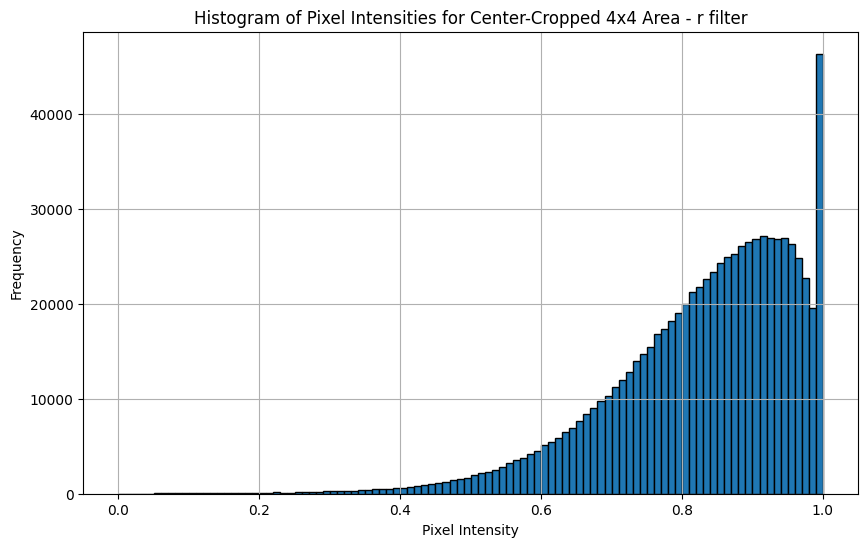

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle

images = sampled_images

# Ensure images are in the expected shape (256, 256, 3)


# Extract the center-cropped 10x10 area from each image and compute the histogram
center_cropped_tensors = images[:, :, 126:130, 126:130]

# Flatten the cropped tensors and compute the histogram of pixel intensities
pixel_intensities = center_cropped_tensors.flatten()
hist, bins = np.histogram(pixel_intensities, bins=50, range=(0, 1))

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(pixel_intensities, bins=100, range=(0, 1), edgecolor='black')
plt.title('Histogram of Pixel Intensities for Center-Cropped 4x4 Area - r filter')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
np.var(pixel_intensities.numpy())

0.017445443